# patch generation guidebook

작성자: PathFinder lab 소속 이혜성 (gotjd709@gmail.com)

편집자: MAI&CV lab 소속 오예인 (yeinoh36@gmail.com)

## 1. [openslide](https://openslide.org/api/python/) base guide

- open_slide 메서드만 사용할 예정
- deepzoom 메서드는 생략
- 활용 프로젝트 특성에 맞춰 annotation 파트 생략

In [ ]:
# !apt-get install openslide-tools
# !pip install openslide-python

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


### 1-1. thumbnail 확인

In [1]:
import openslide

slide_path = "/data3/yumi/TCGA_STAD/0c359076-cf9d-46ea-94fa-9eb9a60a08ab/TCGA-VQ-A8PC-01Z-00-DX1.03BD1821-DB4A-4FAB-AA6A-A8C91E6215F4.svs"
slide = openslide.open_slide(slide_path)

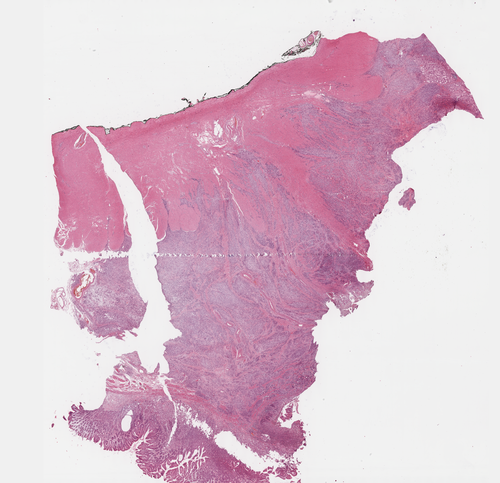

In [2]:
slide.get_thumbnail(size=(500,500))

### 1-2. level의 개수 및 해당 크기 확인

In [3]:
print('level의 개수:', slide.level_count)

for i in range(slide.level_count):
    print(f'level {i}의 크기: {slide.level_dimensions[i]}, level 0에서 {round(slide.level_downsamples[i])}만큼 축소')

level의 개수: 4
level 0의 크기: (91632, 88519), level 0에서 1만큼 축소
level 1의 크기: (22908, 22129), level 0에서 4만큼 축소
level 2의 크기: (5727, 5532), level 0에서 16만큼 축소
level 3의 크기: (2863, 2766), level 0에서 32만큼 축소


### 1-3. slide 정보 확인

In [4]:
dict(slide.properties)

{'aperio.AppMag': '40',
 'aperio.DSR ID': 'resc3-dsr2',
 'aperio.Date': '04/07/14',
 'aperio.DisplayColor': '0',
 'aperio.Exposure Scale': '0.000001',
 'aperio.Exposure Time': '109',
 'aperio.Filename': 'TCGA-VQ-A8PC-01Z-00-DX1',
 'aperio.Focus Offset': '0.000000',
 'aperio.ICC Profile': 'ScanScope v1',
 'aperio.ImageID': '155042',
 'aperio.Left': '19.050732',
 'aperio.LineAreaXOffset': '0.006121',
 'aperio.LineAreaYOffset': '-0.001548',
 'aperio.LineCameraSkew': '0.000000',
 'aperio.MPP': '0.2525',
 'aperio.OriginalHeight': '88619',
 'aperio.OriginalWidth': '93472',
 'aperio.Parmset': 'GOG136 on O: Drive',
 'aperio.ScanScope ID': 'SS1763CNTLR',
 'aperio.StripeWidth': '2032',
 'aperio.Time': '14:49:21',
 'aperio.Time Zone': 'GMT-04:00',
 'aperio.Title': 'TCGA-VQ-A8PC-01Z-00-DX1',
 'aperio.Top': '24.438669',
 'aperio.User': 'ee6aa2ee-3bdf-4e33-9e3e-e499f62026cf',
 'openslide.associated.label.height': '715',
 'openslide.associated.label.width': '718',
 'openslide.associated.macro.height'

### 1-4. level 0에서의 MPP 및 배율 확인

|MPP|0.25|0.5|1|2|4|
|---|---|---|---|---|---|
|Resolution|40X|20X|10X|5X|2.5X|

In [6]:
level0_mpp = round(float(slide.properties.get('openslide.mpp-x')),2)
print(f'level 0에서 MPP: {level0_mpp}')
print(f'level 0에서 배율: {round(1/level0_mpp)*100}배')

level 0에서 MPP: 0.25
level 0에서 배율: 400배


### 1-5. read_region을 활용한 관심 영역 불러오기

In [10]:
print(slide.level_count)

4


level_dimensions은    (w, h) :: (2863, 2766)
whole_image의 shape은 (h, w, 3) :: (2766, 2863, 3)


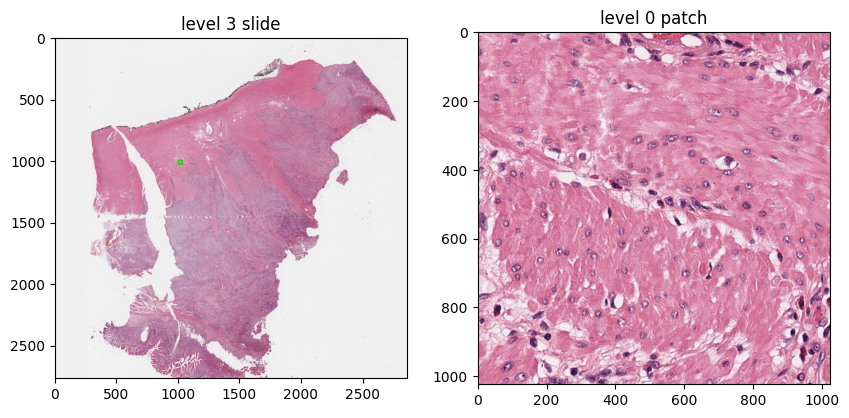

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

x_start = 32000
y_start = 32000
patch_size = 1024

min_level = slide.level_count-1
min_downsample = slide.level_downsamples[slide.level_count-1]
min_size = slide.level_dimensions[slide.level_count-1]
print('level_dimensions은    (w, h) ::', min_size)

whole_region = slide.read_region(location=(0,0), level=min_level, size=min_size)
whole_image = np.array(whole_region)[...,:3]
start_point = (int(x_start//min_downsample), int(y_start//min_downsample))
end_point = (int((x_start+patch_size)//min_downsample), int((y_start+patch_size)//min_downsample))
whole_image_box = cv2.rectangle(whole_image.copy(), start_point, end_point, (0,220,0), 10)
print('whole_image의 shape은 (h, w, 3) ::', whole_image.shape)

roi_region = slide.read_region(location=(x_start,y_start), level=0, size=(patch_size,patch_size))
roi_image = np.array(roi_region)[...,:3]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(whole_image_box)
plt.title(f'level {min_level} slide')
plt.subplot(1,2,2)
plt.imshow(roi_image)
plt.title(f'level 0 patch')
plt.show()

## 2. tissue mask generation

### 2-1. HSV 색상 활용

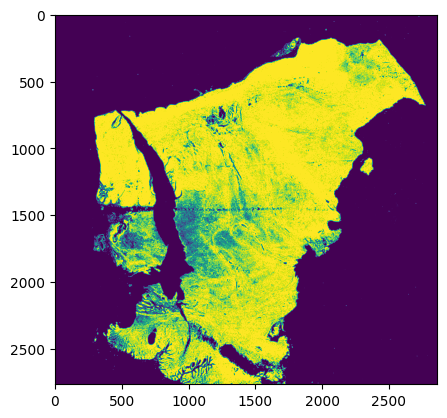

In [11]:
from skimage    import filters

hsv = cv2.cvtColor(whole_image, cv2.COLOR_RGB2HSV)
tissue_S = hsv[:, :, 1] > filters.threshold_otsu(hsv[:, :, 1])

plt.imshow(tissue_S)
plt.show()

In [12]:
print(filters.threshold_otsu(hsv[:, :, 1]))

46


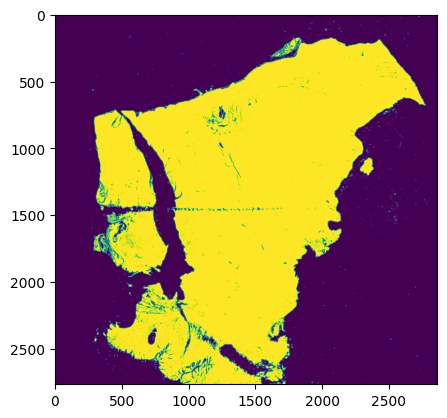

In [17]:
hsv = cv2.cvtColor(whole_image, cv2.COLOR_RGB2HSV)
tissue_S = hsv[:, :, 1] > 10

plt.imshow(tissue_S)
plt.show()

### 2-2. RGB 색상 활용

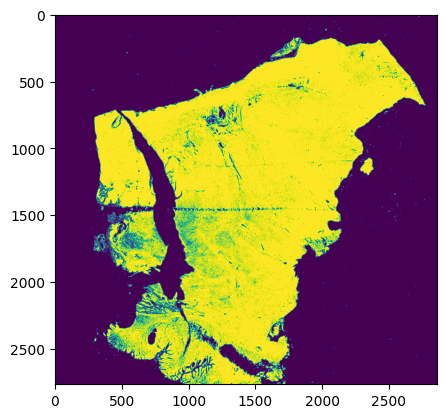

In [18]:
background_R = whole_image[:, :, 0] > filters.threshold_otsu(whole_image[:, :, 0])
background_G = whole_image[:, :, 1] > filters.threshold_otsu(whole_image[:, :, 1])
background_B = whole_image[:, :, 2] > filters.threshold_otsu(whole_image[:, :, 2])
tissue_RGB = np.logical_not(background_R & background_G & background_B)

plt.imshow(tissue_RGB)
plt.show()

### 2-3. 모두 활용

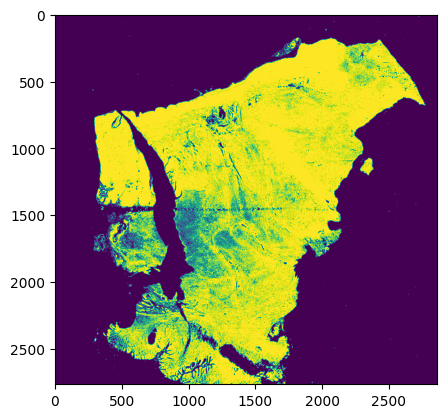

In [19]:
def get_tissue_mask(rgb_image):
    hsv = cv2.cvtColor(rgb_image,cv2.COLOR_RGB2HSV)
    tissue_S = hsv[:, :, 1] > filters.threshold_otsu(hsv[:, :, 1])
    background_R = rgb_image[:, :, 0] > filters.threshold_otsu(rgb_image[:, :, 0])
    background_G = rgb_image[:, :, 1] > filters.threshold_otsu(rgb_image[:, :, 1])
    background_B = rgb_image[:, :, 2] > filters.threshold_otsu(rgb_image[:, :, 2])
    tissue_RGB = np.logical_not(background_R & background_G & background_B)
    mask = tissue_S & (tissue_RGB)
    ret = np.array(mask).astype(np.uint8)
    return ret

tissue_mask = get_tissue_mask(whole_image)

plt.imshow(tissue_mask)
plt.show()

## 3. annotation with image
: 프로젝트 데이터에는 annotation 파일이 존재하지 않으며 프로젝트에는 해당 정보가 사용되지 않음.

### 3-1. annotation 추출

In [13]:
from lxml    import etree

anno_path = '/content/drive/MyDrive/Camelyon16_example/tumor_091.xml'

def get_anno_list(anno_path, min_size, min_downsample):
    pts_list = []
    trees = etree.parse(anno_path).getroot()[0]

    for tree in trees:
        if (tree.get('PartOfGroup') == 'Tumor'):
            regions = tree.findall('Coordinates')
            for region in regions:
                coordinates = region.findall('Coordinate')
                pts = list()
                for coord in coordinates:
                      x = float(coord.get('X'))
                      y = float(coord.get('Y'))
                      x = np.clip(round(x/min_downsample), 0, round(min_size[0]))
                      y = np.clip(round(y/min_downsample), 0, round(min_size[1]))
                      pts.append((x,y))
                pts_list.append(pts)
    return pts_list

pts_list = get_anno_list(anno_path, min_size, min_downsample)
print(pts_list[0][:4])

[(285, 288), (284, 288), (284, 287), (284, 287)]


### 3-2. annotation mask 생성

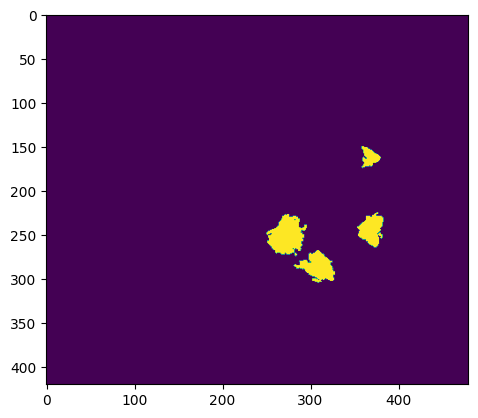

In [14]:
import cv2

def get_anno_mask(pts_list, min_size):
    # 주의 numpy로 mask 생성 시 w,h 순서가 아닌 h,w !!
    mask = np.zeros((min_size[1],min_size[0])).astype(np.uint8)
    for pts in pts_list:
        point = [np.array(pts, dtype=np.int32)]
        mask = cv2.fillPoly(mask, point, 1)
    return mask

mask = get_anno_mask(pts_list, min_size)
plt.imshow(mask)
plt.show()

## 4. patch generation

### 4-1. 마스크의 비율

In [21]:
def get_ratio_mask(patch):
    h_, w_ = patch.shape[0], patch.shape[1]
    n_total = h_*w_
    n_cell = np.count_nonzero(patch)
    if (n_cell != 0):
        return n_cell*1.0/n_total*1.0
    else:
        return 0

### 4-2. 이미지 저장

In [22]:
def save_image(save_path, patch_name, image_patch):
    os.makedirs(save_path, exist_ok = True)
    cv2.imwrite(os.path.join(save_path, patch_name), image_patch)

### 4-3. 패치 생성

In [23]:
def execute_patch(image_patch, target_patch_size, save_path, start_levelm_x, start_levelm_y, patch_count, patch_label):
    resize_image = cv2.resize(image_patch, (target_patch_size,target_patch_size), cv2.INTER_AREA)
    save_image(save_path, f'{start_levelm_x}_{start_levelm_y}_{patch_count}_{patch_label}.png', resize_image)

### 4-4. Sliding Window Algorithm

In [26]:
from tqdm import trange
import os

# setting
target_patch_size = 256
target_mpp = 1

tissue_ratio = 0.3
# tumor_ratio = 0.5     -> annotation 파일 X
save_path = '/data3/yein/TCGA_STAD/0c359076-cf9d-46ea-94fa-9eb9a60a08ab'

# redefinition
slide_path = '/data3/yumi/TCGA_STAD/0c359076-cf9d-46ea-94fa-9eb9a60a08ab/TCGA-VQ-A8PC-01Z-00-DX1.03BD1821-DB4A-4FAB-AA6A-A8C91E6215F4.svs'
slide = openslide.open_slide(slide_path)

min_level = slide.level_count-1
min_downsample = slide.level_downsamples[slide.level_count-1]
min_size = slide.level_dimensions[slide.level_count-1]

whole_region = slide.read_region(location=(0,0), level=min_level, size=min_size)
whole_image = np.array(whole_region)[...,:3]
tissue_mask = get_tissue_mask(whole_image)

## annotation 파일 X
# anno_path = '/content/drive/MyDrive/Camelyon16_example/tumor_091.xml'
# pts_list = get_anno_list(anno_path, min_size, min_downsample)
# tumor_mask = get_anno_mask(pts_list, min_size)

# level 0 patch size
level0_mpp = round(float(slide.properties.get('openslide.mpp-x')),2)
level0_patch_size = int((target_patch_size*target_mpp)/level0_mpp)
level0_size = slide.level_dimensions[0]

# level min patch size & mpp
levelm_mpp = level0_mpp*min_downsample
levelm_patch_size = int((target_patch_size*target_mpp)/levelm_mpp)

# Sliding Window
patch_count = 0

for start_level0_y in trange(0, level0_size[1], level0_patch_size):
    for start_level0_x in range(0, level0_size[0], level0_patch_size):
        start_levelm_x = int(start_level0_x/min_downsample)
        start_levelm_y = int(start_level0_y/min_downsample)
        end_levelm_x = int((start_level0_x+level0_patch_size)/min_downsample)
        end_levelm_y = int((start_level0_y+level0_patch_size)/min_downsample)

        tissue_mask_patch = tissue_mask[start_levelm_y:end_levelm_y, start_levelm_x:end_levelm_x]
        # tumor_patch = tumor_mask[start_levelm_y:end_levelm_y, start_levelm_x:end_levelm_x]

        if (get_ratio_mask(tissue_mask_patch) >= tissue_ratio):
            image_patch = np.array(slide.read_region(
                location = (start_level0_x, start_level0_y),
                level = 0,
                size = (level0_patch_size, level0_patch_size)
            )).astype(np.uint8)[...,:3]
            patch_count += 1
            # if (get_ratio_mask(tumor_patch) >= tumor_ratio):
            #     execute_patch(image_patch, target_patch_size, save_path, start_level0_x, start_level0_y, patch_count, 1)
            # else:
            execute_patch(image_patch, target_patch_size, save_path, start_level0_x, start_level0_y, patch_count, 0)

100%|██████████| 87/87 [02:30<00:00,  1.73s/it]
